In [ ]:
import numpy as np
import time
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

from qiskit.primitives import StatevectorSampler
from qiskit_machine_learning.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit.circuit.library import ZZFeatureMap


def normalize_kernel_matrix(K_train, K_test=None):
    diag_train = np.sqrt(np.diag(K_train))
    diag_train = np.where(diag_train < 1e-10, 1e-10, diag_train)
    K_train_norm = K_train / np.outer(diag_train, diag_train)

    if K_test is None:
        return K_train_norm

    if K_test.shape[0] == K_test.shape[1]:
        diag_test = np.sqrt(np.diag(K_test))
    else:
        diag_test = np.sqrt(np.diag(K_test @ K_test.T))

    diag_test = np.where(diag_test < 1e-10, 1e-10, diag_test)
    K_test_norm = K_test / np.outer(diag_test, diag_train)

    return K_train_norm, K_test_norm


data = load_breast_cancer()
X = data.data
y = data.target

print("\nCARGANDO DATASET BREAST CANCER...")

# Escalado estándar inicial
X = StandardScaler().fit_transform(X)

# Reducimos dimensionalidad para evitar demasiados qubits
pca = PCA(n_components=6, random_state=42)
X_pca = pca.fit_transform(X)
print(f"Dimensión original: {data.data.shape[1]}, después de PCA: {X_pca.shape[1]}")

# Escalado angular [0, π] para el circuito cuántico
angular_scaler = MinMaxScaler(feature_range=(0, np.pi))
X_q = angular_scaler.fit_transform(X_pca)

# División train/test
X_train_q, X_test_q, y_train, y_test = train_test_split(
    X_q, y, test_size=0.25, random_state=42, stratify=y
)

print(f"Train: {len(X_train_q)}, Test: {len(X_test_q)}")


feature_map = ZZFeatureMap(
    feature_dimension=X_pca.shape[1],  # = 6 qubits
    reps=2,
    entanglement="full"
)

sampler = StatevectorSampler()
fidelity = ComputeUncompute(sampler=sampler)

quantum_kernel = FidelityQuantumKernel(
    feature_map=feature_map,
    fidelity=fidelity
)


print("\nCALCULANDO QUANTUM KERNEL...")

start_total = time.time()

print(" → Kernel de entrenamiento...")
t0 = time.time()
K_train_raw = quantum_kernel.evaluate(X_train_q)
t_train = time.time() - t0
print(f"   Tiempo: {t_train:.2f} s")

print(" → Kernel de test...")
t0 = time.time()
K_test_raw = quantum_kernel.evaluate(X_test_q, X_train_q)
t_test = time.time() - t0
print(f"   Tiempo: {t_test:.2f} s")

total_q_time = time.time() - start_total
print(f"Tiempo total quantum kernel: {total_q_time:.2f} s")

# Normalizar
K_train_q, K_test_q = normalize_kernel_matrix(K_train_raw, K_test_raw)



print("\nENTRENANDO SVM CUÁNTICO...")

svc_q = SVC(kernel="precomputed")
svc_q.fit(K_train_q, y_train)
preds_q = svc_q.predict(K_test_q)
acc_q = accuracy_score(y_test, preds_q)

print(f"Accuracy Quantum Kernel: {acc_q:.3f}")



print("\nKERNELS CLÁSICOS...")

X_train_pca, X_test_pca, _, _ = train_test_split(
    X_pca, y, test_size=0.25, random_state=42, stratify=y
)

svc_rbf = SVC(kernel="rbf")
svc_rbf.fit(X_train_pca, y_train)
acc_rbf = accuracy_score(y_test, svc_rbf.predict(X_test_pca))
print(f" Accuracy RBF:      {acc_rbf:.3f}")

svc_poly = SVC(kernel="poly", degree=3)
svc_poly.fit(X_train_pca, y_train)
acc_poly = accuracy_score(y_test, svc_poly.predict(X_test_pca))
print(f" Accuracy Poly:     {acc_poly:.3f}")

svc_lin = SVC(kernel="linear")
svc_lin.fit(X_train_pca, y_train)
acc_lin = accuracy_score(y_test, svc_lin.predict(X_test_pca))
print(f" Accuracy Linear:   {acc_lin:.3f}")


print("\nRESULTADOS FINALES")
print(f"{'Modelo':<30} {'Accuracy':>10} {'Tiempo':>10}")
print(f"{'Quantum Kernel (6 qubits)':<30} {acc_q:>10.3f} {total_q_time:>10.2f}")
print(f"{'RBF Kernel':<30} {acc_rbf:>10.3f} {'<1s':>10}")
print(f"{'Polynomial Kernel':<30} {acc_poly:>10.3f} {'<1s':>10}")
print(f"{'Linear Kernel':<30} {acc_lin:>10.3f} {'<1s':>10}")

print("\nANÁLISIS:")
best_classical = max(acc_rbf, acc_poly, acc_lin)
if acc_q > best_classical:
    print(f" ✔ Quantum Kernel supera a los modelos clásicos por {acc_q - best_classical:.3f}")
else:
    print(f" ✘ Mejor clásico: {best_classical:.3f} | Quantum: {acc_q:.3f}")



CARGANDO DATASET BREAST CANCER...
Dimensión original: 30, después de PCA: 6
Train: 426, Test: 143

CALCULANDO QUANTUM KERNEL...
 → Kernel de entrenamiento...
   Tiempo: 1700.26 s
 → Kernel de test...
   Tiempo: 1144.19 s
Tiempo total quantum kernel: 2844.45 s

ENTRENANDO SVM CUÁNTICO...
Accuracy Quantum Kernel: 0.818

KERNELS CLÁSICOS...
 Accuracy RBF:      0.958
 Accuracy Poly:     0.937
 Accuracy Linear:   0.972

RESULTADOS FINALES
Modelo                           Accuracy     Tiempo
Quantum Kernel (6 qubits)           0.818    2844.45
RBF Kernel                          0.958        <1s
Polynomial Kernel                   0.937        <1s
Linear Kernel                       0.972        <1s

ANÁLISIS:
 ✘ Mejor clásico: 0.972 | Quantum: 0.818


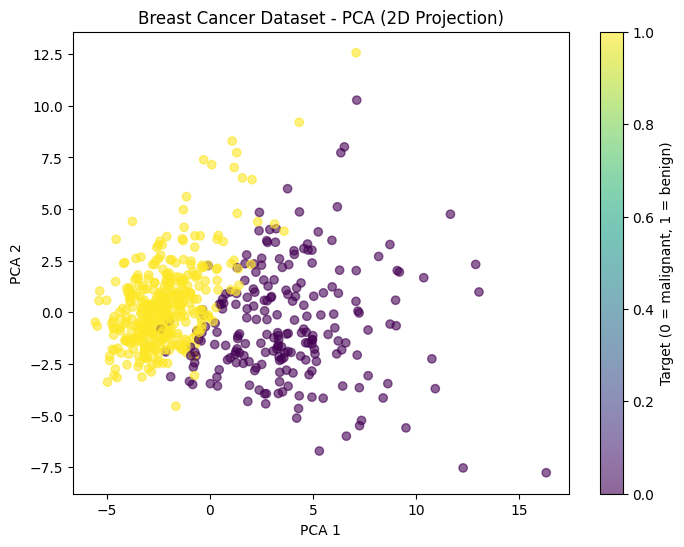

In [2]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA   

data = load_breast_cancer()
X = data.data
y = data.target  # 0 = maligno, 1 = benigno

# Estandarizar características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reducir a 2 dimensiones con PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)

# Graficar
plt.figure(figsize=(8,6))
plt.scatter(pca_result[:,0], pca_result[:,1], 
            alpha=0.6, c=y, cmap='viridis')

plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("Breast Cancer Dataset - PCA (2D Projection)")
plt.colorbar(label="Target (0 = malignant, 1 = benign)")
plt.show()